# Implicit Regularization

<a target="_blank" href="https://colab.research.google.com/github/GaiaSaveri/intro-to-ml/blob/main/solved-notebooks/SOLVED-Lab-12.Implicit_regularization.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this lab, we will study the *implicit bias* induced by *Gradient Descent* optimization in the simple case of *linear regression*, fitted on a toy dataset. In particular, we will show that GD-optimized weights converge to the **least norm** solution of the linear regression problem.

Nota: La "least norm solution of the linear regression problem" è una soluzione al problema di regressione lineare che minimizza la norma dei coefficienti del modello, oltre ad adattarsi ai dati.

La regressione lineare è un metodo di apprendimento statistico utilizzato per modellare la relazione tra una variabile dipendente (o variabile di risposta) e una o più variabili indipendenti (o predittori). L'obiettivo principale della regressione lineare è trovare i coefficienti che minimizzano la somma dei quadrati degli errori, ovvero la differenza tra i valori osservati e i valori predetti dal modello.

Nel contesto di un problema di regressione lineare, la soluzione a norma minima è quella che ha il vettore dei coefficienti con la norma più piccola tra tutte le possibili soluzioni. In altre parole, questa soluzione cerca di mantenere i coefficienti del modello il più vicino possibile allo zero, pur trovando una soluzione che si adatti ai dati.

Una possibile ragione per cercare una soluzione a norma minima è la regolarizzazione, che è una tecnica utilizzata per prevenire il sovradattamento del modello ai dati di addestramento e migliorare la sua capacità di generalizzazione su nuovi dati. Un esempio di regolarizzazione che incoraggia una soluzione a norma minima è la regolarizzazione L2, comunemente nota come ridge regression.

Per trovare la soluzione a norma minima in un problema di regressione lineare, si utilizzano spesso tecniche matematiche come la pseudo-inversa di Moore-Penrose o metodi di ottimizzazione come il metodo del gradiente.

Then, we will study how different initializations and different optimizers affect the weights learned by a *Convolutional neural network*.


An analysis of implicit regularization (aka implicit bias) induced by *Stochastic Gradient Descent* in *full-width linear fully-connected* and *full-width linear convolutional* neural networks is provided in [this paper](https://arxiv.org/abs/1806.00468).



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA
import random

random.seed(546)
np.random.seed(987)

## Linear regression


Let's first create a function which generates data. You've already seen this in many previous labs.

In [2]:
# funzione per generare i dati
def datagen(d, points, m, M, w, sigma):
    X = np.zeros((points,d))
    for i in range(points):
        X[i,:] = np.random.uniform(m, M, d)
    eps = np.random.normal(0, sigma, points)
    y = np.dot(X,w) + eps 
    return X, y

We can visualise the data created if $d=1$.

C:\Users\Erion\AppData\Local\Temp\ipykernel_6616\2039957168.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


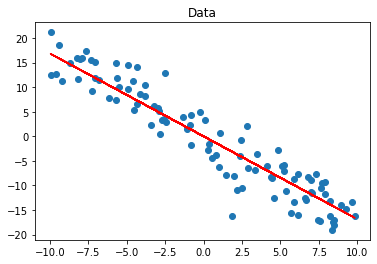

In [3]:
d = 1 # dimensione
w = np.random.normal(0, 1, d) # vettore dei pesi
sigma = 3 # varianza del rumore
points = 100 # numero di punti
m = -10 
M = 10

X, y = datagen(d, points, m, M, w, sigma)
fig, ax =plt.subplots()
ax.scatter(X,y)
ax.plot(X,np.dot(X,w), color = "red")
ax.set_title('Data')

fig.show()

Let's now create the data set that we will use, in a higher dimension.

In [4]:
# dataset che realmente utilizziamo

d = 10
w = np.random.normal(0,1,d)
sigma = 3
points = 1000
m = -10
M = 10

X, y = datagen(d, points, m, M, w, sigma)

In the case of **linear regression**, fitted by means of *least squares*, we optimize the following loss function:
$$
L=\|y-Xw\|_{2}^{2}.
$$

If we choose the *GD* optimization algorithm, we perform weight updates proportional to the gradient of the loss function:
$$
\nabla_{w} L = -X(y-Xw).
$$

Additionally, notice that the **least norm** solution of the *linear regression* problem is given by:
$$
w^{*}=(X^{T}X + \lambda I)^{-1}X^{T}y.
$$

##### 1. Compute the least norm solution of the linear regression problem.

In [5]:
def least_norm_reg(X, y, lam):
    # The regularizer `lam` allows to make the matrix invertible!
    return np.linalg.inv(X.T.dot(X) + lam * np.eye(d)).dot(X.T).dot(y)

##### 2. Perform GD optimization of the linear regression problem iteratively, storing the weights at each iteration.

In [6]:
# gradient of the MSE corresponding to the ordinary least squares solution for linear regression
def OLSGradient(X, y, w):
    points = X.shape[0]
    return X.T.dot(X.dot(w) -y ) / points

# gradient descent for linear regression with learning rate gamma
def GD(X, y, Iter, gamma):
    points = X.shape[0]
    d = X.shape[1]
    w0 = np.random.normal(0, 0.1, d) # initialise the weights randomly
    ws = [w0] # salvo i pesi ad ogni iterazione
    for i in range(Iter):
        ws.append(ws[-1] - gamma * OLSGradient(X, y, ws[-1])) # update the weights
    return ws

##### 3. Plot the evolution of the weights during GD optimization, showing their relation with the least norm solution.

In [7]:
W_opt = least_norm_reg(X, y, 1e-6)

W_gd = GD(X, y, Iter = 50, gamma = 0.01)

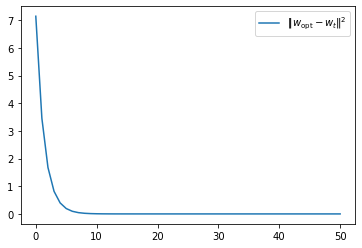

In [8]:
plt.plot([np.linalg.norm(W_opt - w) ** 2 for w in W_gd], label="$|\!|w_{\mathrm{opt}}-w_{t}|\!|^2$")
plt.legend()

Si vede che la differenza tra i pesi ottenuti da least_norm_reg e GD convergono a 0.
NOTA: cambiando gamma si vede che la convergenza a volte non avviene, c'è un esplosione dei pesi.

## Convolutional Neural Network

*Remember to enable GPU acceleration! `Runtime` > `Change runtime type` > `Hardware acceleration` > `GPU`*

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from time import time

torch.manual_seed(0)

### Loading the data set

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) data set consists of $60000$ $32x32$ colour images in $10$ classes, with $6000$ images per class. There are $50000$ training images and $10000$ test images. 


In [10]:
BATCH_SIZE = 32

# Convert data to PyTorch tensor form and normalise it
# The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
# qui normalizzo cosi tutti i tensorti sono normalizzati tra -1 e 1
data_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## download and load training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
# creo il dataloader per il training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 170498071/170498071 [00:18<00:00, 9113025.56it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data


oggi basta solo il training set visto che vogliamo solamente studiare l'implict bias.

#### Visualising the data

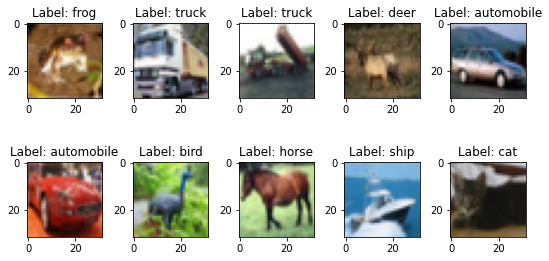

In [11]:
num_row = 2
num_col = 5

classes = trainset.classes

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(classes[trainset.targets[i]]))
plt.tight_layout()
plt.show()

In [12]:
# printing data shapes 
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Single image dimensions: (32, 32, 3)
Image batch dimensions: torch.Size([32, 3, 32, 32])
Image label dimensions: torch.Size([32])


Questa volta abbiamo 32x3x32 immagini, 32x32 è la dimensione dell'immagine, 3 è il numero di canali (RGB).

### Defining the model

##### 4. Define a CNN with one convolutional layer and two linear layers (be careful of the dimensions!)

In [13]:
# creami un modello di rete neurale convoluzionale
class CNN(nn.Module):
    # definisco il costruttore
    def __init__(self):
        # chiamo il costruttore della classe padre
        super(CNN, self).__init__()
        
        # definisco il layer convoluzionale   
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        # LAYER LINEARE (out_chanel di sopra*26*26, 128 è la dimensionalità del layer sucessivo
        self.l1 = nn.Linear(32 * 30 * 30, 128) # metto 30 perchè il kernel è 3x3 e quindi perdo 2 righe e 2 colonne
        # altro LAYER LINEARE: input è l'output di quello prima, e 10 è OUTPUT (numeri da 0 a 9)
        self.l2 = nn.Linear(128, 10)
        
    def forward(self, x):
        # Convolution: BSx3x32x32 => BSx32x30x30
        x = self.conv1(x)

        # Activation function
        x = F.relu(x)

        # flatten => BS x (32*30*30) = BS x 28800
        x = x.flatten(start_dim = 1)

        # BSx(32*30*30) => BSx128
        x = self.l1(x)

        x = F.relu(x)

        # BSx128 => BSx10
        x = self.l2(x)

        return x

#### Defining the auxiliary functions

In [15]:
# functions

def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def compute_weight_norm(model):
    norm = 0.0
    for name, param in model.named_parameters():
      if "weight" in name:
        norm += torch.norm(param.data, p= 2)
    return norm.cpu().item()


def train_model(model, num_epochs, trainloader, criterion, optimizer):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    losses = []
    accs = []

    norms = []
    
    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in enumerate(trainloader):
            
            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)
        
            
        losses.append(train_running_loss / i)
        accs.append(train_acc/i)
        
        norms.append(compute_weight_norm(model))
        model.eval()
        print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}") 
    
    return losses, accs, norms

#### Training with different optimizers

An optimizer is an algorithm that adjusts the weights of a model in order to minimize its loss function. There are many different optimizers available in deep learning, each with its own strengths and weaknesses, and its choice depends on the specific problem and model being trained, and is often a matter of trial and error.   
Different optimizers can affect the weights of a model in different ways because they use different algorithms to update the weights during training.

Perchè cambiando l'optimizer cambiano i pesi? Perchè l'optimizer serve a minimizzare la loss function, e quindi cambia il modo in cui i pesi vengono aggiornati. Ci saranno diversi algoritmi che fanno l'update in modo diverso.

##### 5. Train the model with two different optimizers and see in a plot how the weights differ ([hint](https://pytorch.org/docs/stable/optim.html)).

In [16]:
model = CNN()

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

_, _, W_adam = train_model(model, 10, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 1.4080 | Train Accuracy: 49.7019 | Time: 26.17
Epoch: 2 | Loss: 1.1031 | Train Accuracy: 60.8295 | Time: 21.21
Epoch: 3 | Loss: 0.9446 | Train Accuracy: 66.6773 | Time: 21.31
Epoch: 4 | Loss: 0.8010 | Train Accuracy: 71.5389 | Time: 21.30
Epoch: 5 | Loss: 0.6810 | Train Accuracy: 76.0783 | Time: 21.38
Epoch: 6 | Loss: 0.5700 | Train Accuracy: 80.1336 | Time: 21.88
Epoch: 7 | Loss: 0.4683 | Train Accuracy: 83.6928 | Time: 21.33
Epoch: 8 | Loss: 0.3818 | Train Accuracy: 86.6717 | Time: 20.94
Epoch: 9 | Loss: 0.3077 | Train Accuracy: 89.3746 | Time: 21.55
Epoch: 10 | Loss: 0.2405 | Train Accuracy: 91.7814 | Time: 21.41


In [17]:
model = CNN()

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

_, _, W_SGD = train_model(model, 10, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 1.6951 | Train Accuracy: 40.2989 | Time: 18.48
Epoch: 2 | Loss: 1.3749 | Train Accuracy: 51.1124 | Time: 17.98
Epoch: 3 | Loss: 1.2173 | Train Accuracy: 56.8962 | Time: 17.54
Epoch: 4 | Loss: 1.1164 | Train Accuracy: 60.7054 | Time: 17.85
Epoch: 5 | Loss: 1.0297 | Train Accuracy: 64.0945 | Time: 18.05
Epoch: 6 | Loss: 0.9513 | Train Accuracy: 66.9254 | Time: 17.23
Epoch: 7 | Loss: 0.8719 | Train Accuracy: 69.6603 | Time: 18.35
Epoch: 8 | Loss: 0.7943 | Train Accuracy: 72.5392 | Time: 19.09
Epoch: 9 | Loss: 0.7172 | Train Accuracy: 75.3081 | Time: 18.75
Epoch: 10 | Loss: 0.6410 | Train Accuracy: 78.0490 | Time: 18.92


Adam impara piu velocemente di SGD e reggiunge piu velocemente la norma ottimale dei pesi.
SGD è piu lento e non raggiunge la norma ottimale dei pesi, ha bisogno di piu epoche.

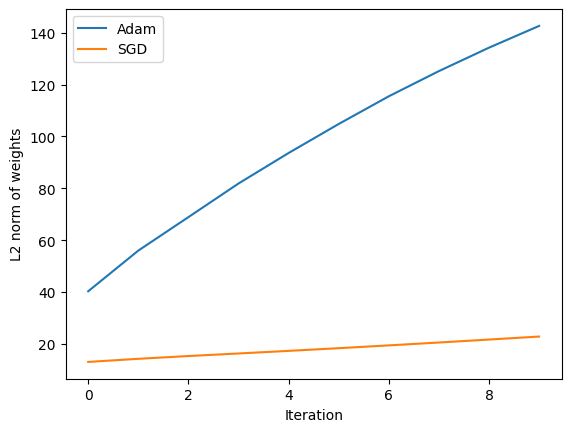

In [ ]:
plt.plot(W_adam, label = "Adam")
plt.plot(W_SGD, label = "SGD")
plt.xlabel('Iteration')
plt.ylabel('L2 norm of weights')
plt.legend()
plt.show()

#### Training with different initializations

By default, linear layers are initialised with a uniform distribution bounded by $\dfrac{1}{\sqrt{in features}}$, while conv2d layers by a uniform distribution bouded by $\dfrac{1}{\sqrt{(in features) \cdot k}}$ , where $k$ is the kernel size.

By changing the default kernel initialization, the weights of the model vary.

##### 6. Try to change the model weight initialization and see how they compare with the ones computed with the default one ([hint](https://pytorch.org/docs/stable/nn.init.html)).

In [18]:
def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        torch.nn.init.ones_(m.weight)

Vediamo cosa succede se al posto di partire con pesi inizializzati da una uniforme, li inizializziamo tutti a 1.

In [19]:
model = CNN()
model.apply(init_weights) # inizializzo i pesi a 1

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

_, _, W_adam_ones = train_model(model, 10, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 3060.1352 | Train Accuracy: 10.2133 | Time: 21.25
Epoch: 2 | Loss: 74.3832 | Train Accuracy: 12.0499 | Time: 22.08
Epoch: 3 | Loss: 3.3857 | Train Accuracy: 13.2923 | Time: 23.75
Epoch: 4 | Loss: 2.3513 | Train Accuracy: 12.1239 | Time: 24.62
Epoch: 5 | Loss: 2.2822 | Train Accuracy: 13.4843 | Time: 23.86
Epoch: 6 | Loss: 2.2073 | Train Accuracy: 18.1898 | Time: 22.02
Epoch: 7 | Loss: 2.0976 | Train Accuracy: 22.6212 | Time: 21.77
Epoch: 8 | Loss: 2.0182 | Train Accuracy: 25.6482 | Time: 21.88
Epoch: 9 | Loss: 1.9834 | Train Accuracy: 26.9886 | Time: 21.10
Epoch: 10 | Loss: 1.9388 | Train Accuracy: 29.1913 | Time: 21.45


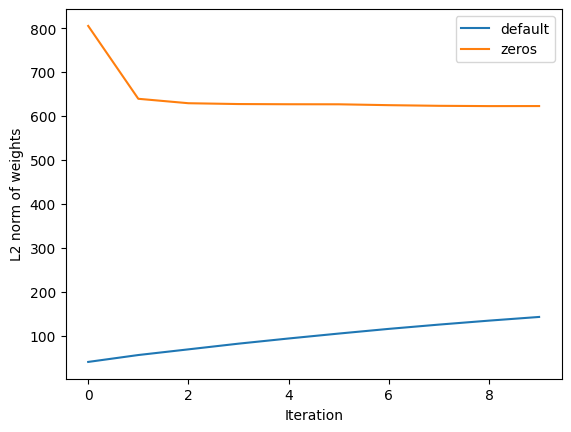

In [ ]:
plt.plot(W_adam, label = "default")
plt.plot(W_adam_ones, label = "ones")
plt.xlabel('Iteration')
plt.ylabel('L2 norm of weights')
plt.legend()
plt.show()

quindi anche la scelta dell'inizializzazione dei pesi cambia i pesi finali a cui arrivo. L'inizializzazione è tanto distante dai paramentri ottimali che ci mette tanto tempo ad imparare.

IN CONLCUSIONE: l'inizializzazione dei pesi e l'optimizer influenzano i pesi finali a cui arrivo.